In [6]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

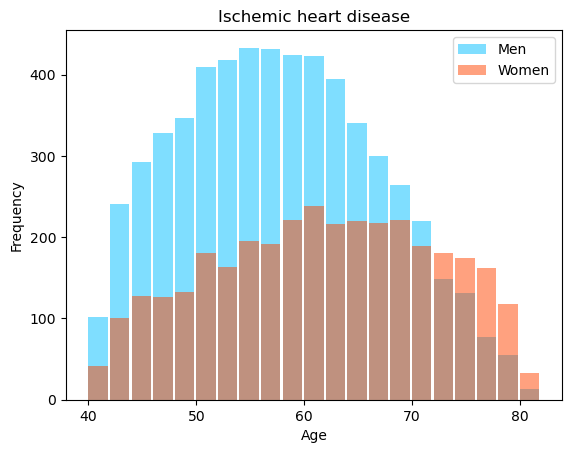

In [7]:
import matplotlib.pyplot as plt
adf = df.copy()
adf["age"] = adf["age"].apply(lambda a: a - (a % 2)) #group even ages
wdf = adf.where(adf.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = adf.where(adf.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
x = wdf["age"]
y = wdf["patient"]
xmen = mdf["age"]
ymen = mdf["patient"]

plt.bar(xmen, ymen, width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(x, y, width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')
# plt.plot(xmen, ymen, color='deepskyblue')
# plt.plot(x, y, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

## Randomized response (local DP)
Below we look at how the count of men vs women with Ischemic heart disease would be effected if the data was gathered using randomized response (coin flipping).

In [8]:
import pandas as pd
import numpy as np

# Recurrent urinary tract infection
falseQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id NOT IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION = 'Ischemic heart disease (disorder)'
);
"""
trueQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION = 'Ischemic heart disease (disorder)'
);
"""

falsedf = pd.read_sql(falseQuery, conn)
truedf = pd.read_sql(trueQuery, conn)

In [9]:
import random as rand

def randomizedResponse(truth):
    if rand.random() < 0.5:
        return truth
    else:
        return rand.random() < 0.5


def rr(yesses, all):
    nos = all - yesses
    rand = 0

    for x in range(yesses):
        if randomizedResponse(True):
            rand = rand + 1
    for x in range(nos):
        if randomizedResponse(False):
            rand = rand + 1

    fakeYesses = all / 4
    return (rand - fakeYesses) * 2

In [10]:
wCounts = []
mCounts = []
for i in range(100):
    womenCount = rr(len(truedf.where(truedf.GENDER == 'F').dropna()),
                    len(falsedf.where(falsedf.GENDER == 'F').dropna()))
    menCount = rr(len(truedf.where(truedf.GENDER == 'M').dropna()), len(falsedf.where(falsedf.GENDER == 'M').dropna()))
    wCounts.append(womenCount)
    mCounts.append(menCount)

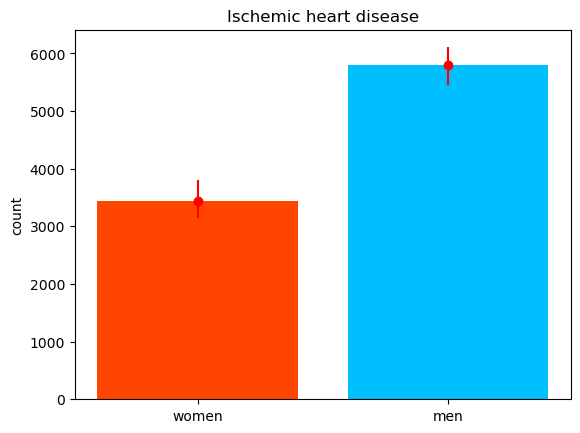

In [11]:
wc = len(truedf.where(truedf.GENDER == 'F').dropna())
mc = len(truedf.where(truedf.GENDER == 'M').dropna())
fig, ax = plt.subplots()

genders = ['women', 'men']
counts = [wc, mc]
bar_colors = ['orangered', 'deepskyblue']

ax.bar(genders, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('Ischemic heart disease')
plt.errorbar(genders, counts, yerr=[[wc - min(wCounts), mc - min(mCounts)], [max(wCounts) - wc, max(mCounts) - mc]],
             fmt="o", color="r")

plt.show()

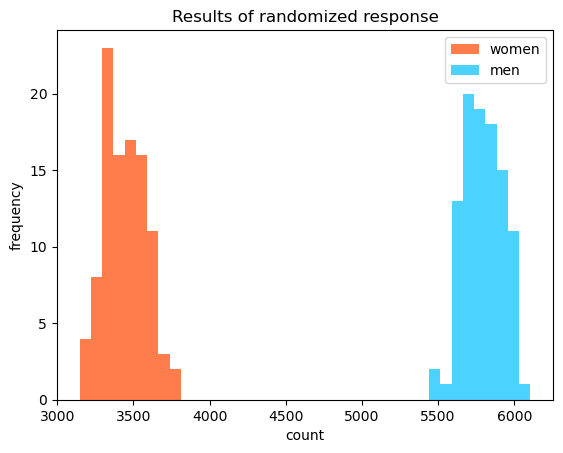

In [12]:
plt.cla()
bins = np.histogram(np.hstack((wCounts, mCounts)), bins=40)[1]
plt.hist(wCounts, bins, color='orangered', label='women', alpha=0.7)
plt.hist(mCounts, bins, color='deepskyblue', label='men', alpha=0.7)
plt.xlabel('count')
plt.ylabel('frequency')
plt.title('Results of randomized response')
plt.legend()
plt.show()